In [ ]:
import re
import multiprocessing as mp
import pandas as pd
from typing import List

# Step 4: Define patterns for feature extraction
patterns = {
    "transcript": re.compile(r'^(NM_\d+\.\d+)'),
    "substitution": re.compile(r'>[ACGT]'),
    "del": re.compile(r'del(?!ins)'),
    "dup": re.compile(r'dup'),
    "insertion": re.compile(r'ins(?!del)'),  # Consolidated insertion pattern
    "delins": re.compile(r'delins'),
    "frameshift": re.compile(r'fs'),
    "splice_site": re.compile(r'\+|-'),
    "missense": re.compile(r'p\.[A-Z][a-z]{2}\d+[A-Z][a-z]{2}'),
    "nonsense": re.compile(r'p\.[A-Z][a-z]{2}\d+Ter'),
    "synonymous": re.compile(r'p\.[A-Z][a-z]{2}\d+='),
    "repeat_variant": re.compile(r'\[\d+\]'),
}

# Step 5: Feature extraction function
def extract_features(hgvs: str) -> dict:
    feat = {
        'hgvs': hgvs,
        'transcript': None,
        'is_substitution': 0,
        'is_deletion': 0,  # Single deletion feature
        'is_insertion': 0,  # Single insertion feature
        'is_duplication': 0,  # Single duplication feature
        'is_delins': 0,
        'is_frameshift': 0,
        'is_splice_site': 0,
        'is_missense': 0,
        'is_nonsense': 0,
        'is_synonymous': 0,
        'is_repeat_variant': 0,
    }
    for key, pattern in patterns.items():
        if key == 'transcript':
            m = pattern.search(hgvs)
            if m:
                feat['transcript'] = m.group(1)
        else:
            feat[f'is_{key}'] = int(bool(pattern.search(hgvs)))
    return feat

# Step 6: Chunk processor
def process_chunk(chunk: List[str]) -> List[dict]:
    return [extract_features(entry) for entry in chunk]

# Step 7: Parallel processing function
def process_hgvs_list_parallel(hgvs_list: List[str], num_processes=None, chunk_size=1000) -> pd.DataFrame:
    if num_processes is None:
        num_processes = mp.cpu_count()
    chunks = [hgvs_list[i:i + chunk_size] for i in range(0, len(hgvs_list), chunk_size)]
    with mp.Pool(processes=num_processes) as pool:
        results = pool.map(process_chunk, chunks)
    flat_results = [item for sublist in results for item in sublist]
    return pd.DataFrame(flat_results)

# Step 8: Run on your cleaned DataFrame (assume 'Name' column)
# Replace 'df' with your original dataframe, if it's called differently
df = pd.read_csv("/content/drive/MyDrive/bioinformatics/cleaned_variant_data.csv")  # Make sure to load your original dataset
hgvs_column = 'Name'  # <- The column from which you want to extract features

# Extract HGVS strings from the 'Name' column, ensure it's a list of strings
hgvs_list = df[hgvs_column].dropna().astype(str).tolist()

# Extract features
features_df = process_hgvs_list_parallel(hgvs_list, chunk_size=100)

# Ensure that no duplicate columns (e.g., 'is_insertion' and 'is_ins') are created.
# We already consolidated the patterns and removed redundancies.

# Merge the original DataFrame with the extracted features (dropping the 'hgvs' column)
final_df = pd.concat([df.reset_index(drop=True), features_df.drop(columns=['hgvs'])], axis=1)

# Step 9: No need to save results, just print the first few rows
print(final_df.head())  # This will print the first few rows of the final DataFrame for review


<ipython-input-1-0378bca3a5b2>:64: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/bioinformatics/cleaned_variant_data.csv")  # Make sure to load your original dataset


                        Type  \
0                      Indel   
1                      Indel   
2  single nucleotide variant   
3  single nucleotide variant   
4  single nucleotide variant   

                                                Name GeneSymbol  \
0  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
1  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
2        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
3        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
4       NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser)    FOXRED1   

             Origin Chromosome      Start       Stop  \
0  germline;unknown          7    4820844    4820847   
1  germline;unknown          7    4781213    4781216   
2          germline         11  126145284  126145284   
3          germline         11  126275389  126275389   
4          germline         11  126147412  126147412   

                                        ReviewStatus  NumberSubmitt

In [ ]:
final_df.columns

Index(['Type', 'Name', 'GeneSymbol', 'Origin', 'Chromosome', 'Start', 'Stop',
       'ReviewStatus', 'NumberSubmitters', 'Grouped_ClinicalSignificance',
       'ReviewConfidence', 'transcript', 'is_substitution', 'is_deletion',
       'is_insertion', 'is_duplication', 'is_delins', 'is_frameshift',
       'is_splice_site', 'is_missense', 'is_nonsense', 'is_synonymous',
       'is_repeat_variant', 'is_del', 'is_dup'],
      dtype='object')

In [ ]:
# Step: Get value counts for the 'is_dup' column
print(final_df['is_dup'].value_counts())


is_dup
0    6157303
1     124930
Name: count, dtype: int64


In [ ]:
# Step: Get value counts for the 'is_dup' column
print(final_df['is_duplication'].value_counts())


is_duplication
0    6282233
Name: count, dtype: int64


In [ ]:
# Check how many rows have the same value in both columns
same_values = (final_df['is_duplication'] == final_df['is_dup']).sum()
print(f"Rows where 'is_duplication' and 'is_dup' are the same: {same_values}")

# Check how many rows have different values in both columns
different_values = (final_df['is_duplication'] != final_df['is_dup']).sum()
print(f"Rows where 'is_duplication' and 'is_dup' are different: {different_values}")


Rows where 'is_duplication' and 'is_dup' are the same: 6157303
Rows where 'is_duplication' and 'is_dup' are different: 124930


In [ ]:
# Drop the 'is_duplication' column
final_df = final_df.drop(columns=['is_duplication'])

# Verify if it's dropped successfully
print(final_df.columns)


Index(['Type', 'Name', 'GeneSymbol', 'Origin', 'Chromosome', 'Start', 'Stop',
       'ReviewStatus', 'NumberSubmitters', 'Grouped_ClinicalSignificance',
       'ReviewConfidence', 'transcript', 'is_substitution', 'is_deletion',
       'is_insertion', 'is_delins', 'is_frameshift', 'is_splice_site',
       'is_missense', 'is_nonsense', 'is_synonymous', 'is_repeat_variant',
       'is_del', 'is_dup'],
      dtype='object')


In [ ]:
# Step: Get value counts for the 'is_dup' column
print(final_df['is_del'].value_counts())



is_del
0    5983057
1     299176
Name: count, dtype: int64


In [ ]:
# Step: Get value counts for the 'is_dup' column
print(final_df['is_deletion'].value_counts())



is_deletion
0    6282233
Name: count, dtype: int64


In [ ]:
# Drop the 'is_duplication' column
final_df = final_df.drop(columns=['is_deletion'])

# Verify if it's dropped successfully
print(final_df.columns)


Index(['Type', 'Name', 'GeneSymbol', 'Origin', 'Chromosome', 'Start', 'Stop',
       'ReviewStatus', 'NumberSubmitters', 'Grouped_ClinicalSignificance',
       'ReviewConfidence', 'transcript', 'is_substitution', 'is_insertion',
       'is_delins', 'is_frameshift', 'is_splice_site', 'is_missense',
       'is_nonsense', 'is_synonymous', 'is_repeat_variant', 'is_del',
       'is_dup'],
      dtype='object')


In [ ]:
# One-hot encode the 'Type' column
type_dummies = pd.get_dummies(df['Type'], prefix='type')

# Concatenate the one-hot encoded columns back to the original DataFrame
final_df = pd.concat([final_df, type_dummies], axis=1)

# Optionally, drop the original 'Type' column if you don't need it anymore
# df = df.drop(columns=['Type'])

# View the updated DataFrame columns
print(final_df.columns)


Index(['Type', 'Name', 'GeneSymbol', 'Origin', 'Chromosome', 'Start', 'Stop',
       'ReviewStatus', 'NumberSubmitters', 'Grouped_ClinicalSignificance',
       'ReviewConfidence', 'transcript', 'is_substitution', 'is_insertion',
       'is_delins', 'is_frameshift', 'is_splice_site', 'is_missense',
       'is_nonsense', 'is_synonymous', 'is_repeat_variant', 'is_del', 'is_dup',
       'type_Complex', 'type_Deletion', 'type_Duplication', 'type_Indel',
       'type_Insertion', 'type_Inversion', 'type_Microsatellite',
       'type_Tandem duplication', 'type_Translocation', 'type_Variation',
       'type_copy number gain', 'type_copy number loss', 'type_protein only',
       'type_single nucleotide variant'],
      dtype='object')


In [ ]:
# Compute correlation matrix
correlation_matrix = final_df.corr(numeric_only=True)

# Display the correlation matrix
print(correlation_matrix)


                                   Start      Stop  NumberSubmitters  \
Start                           1.000000  0.999939         -0.006070   
Stop                            0.999939  1.000000         -0.006134   
NumberSubmitters               -0.006070 -0.006134          1.000000   
ReviewConfidence               -0.008733 -0.008785          0.279563   
is_substitution                 0.008833  0.008212          0.009698   
is_insertion                   -0.004357 -0.004377         -0.010801   
is_delins                      -0.002252 -0.002265         -0.007606   
is_frameshift                  -0.005766 -0.005802          0.014935   
is_splice_site                 -0.002899 -0.002551         -0.032947   
is_missense                    -0.003831 -0.004040          0.005171   
is_nonsense                     0.003833  0.003806          0.046380   
is_synonymous                   0.011807  0.011716          0.027361   
is_repeat_variant               0.000349  0.000335          0.00

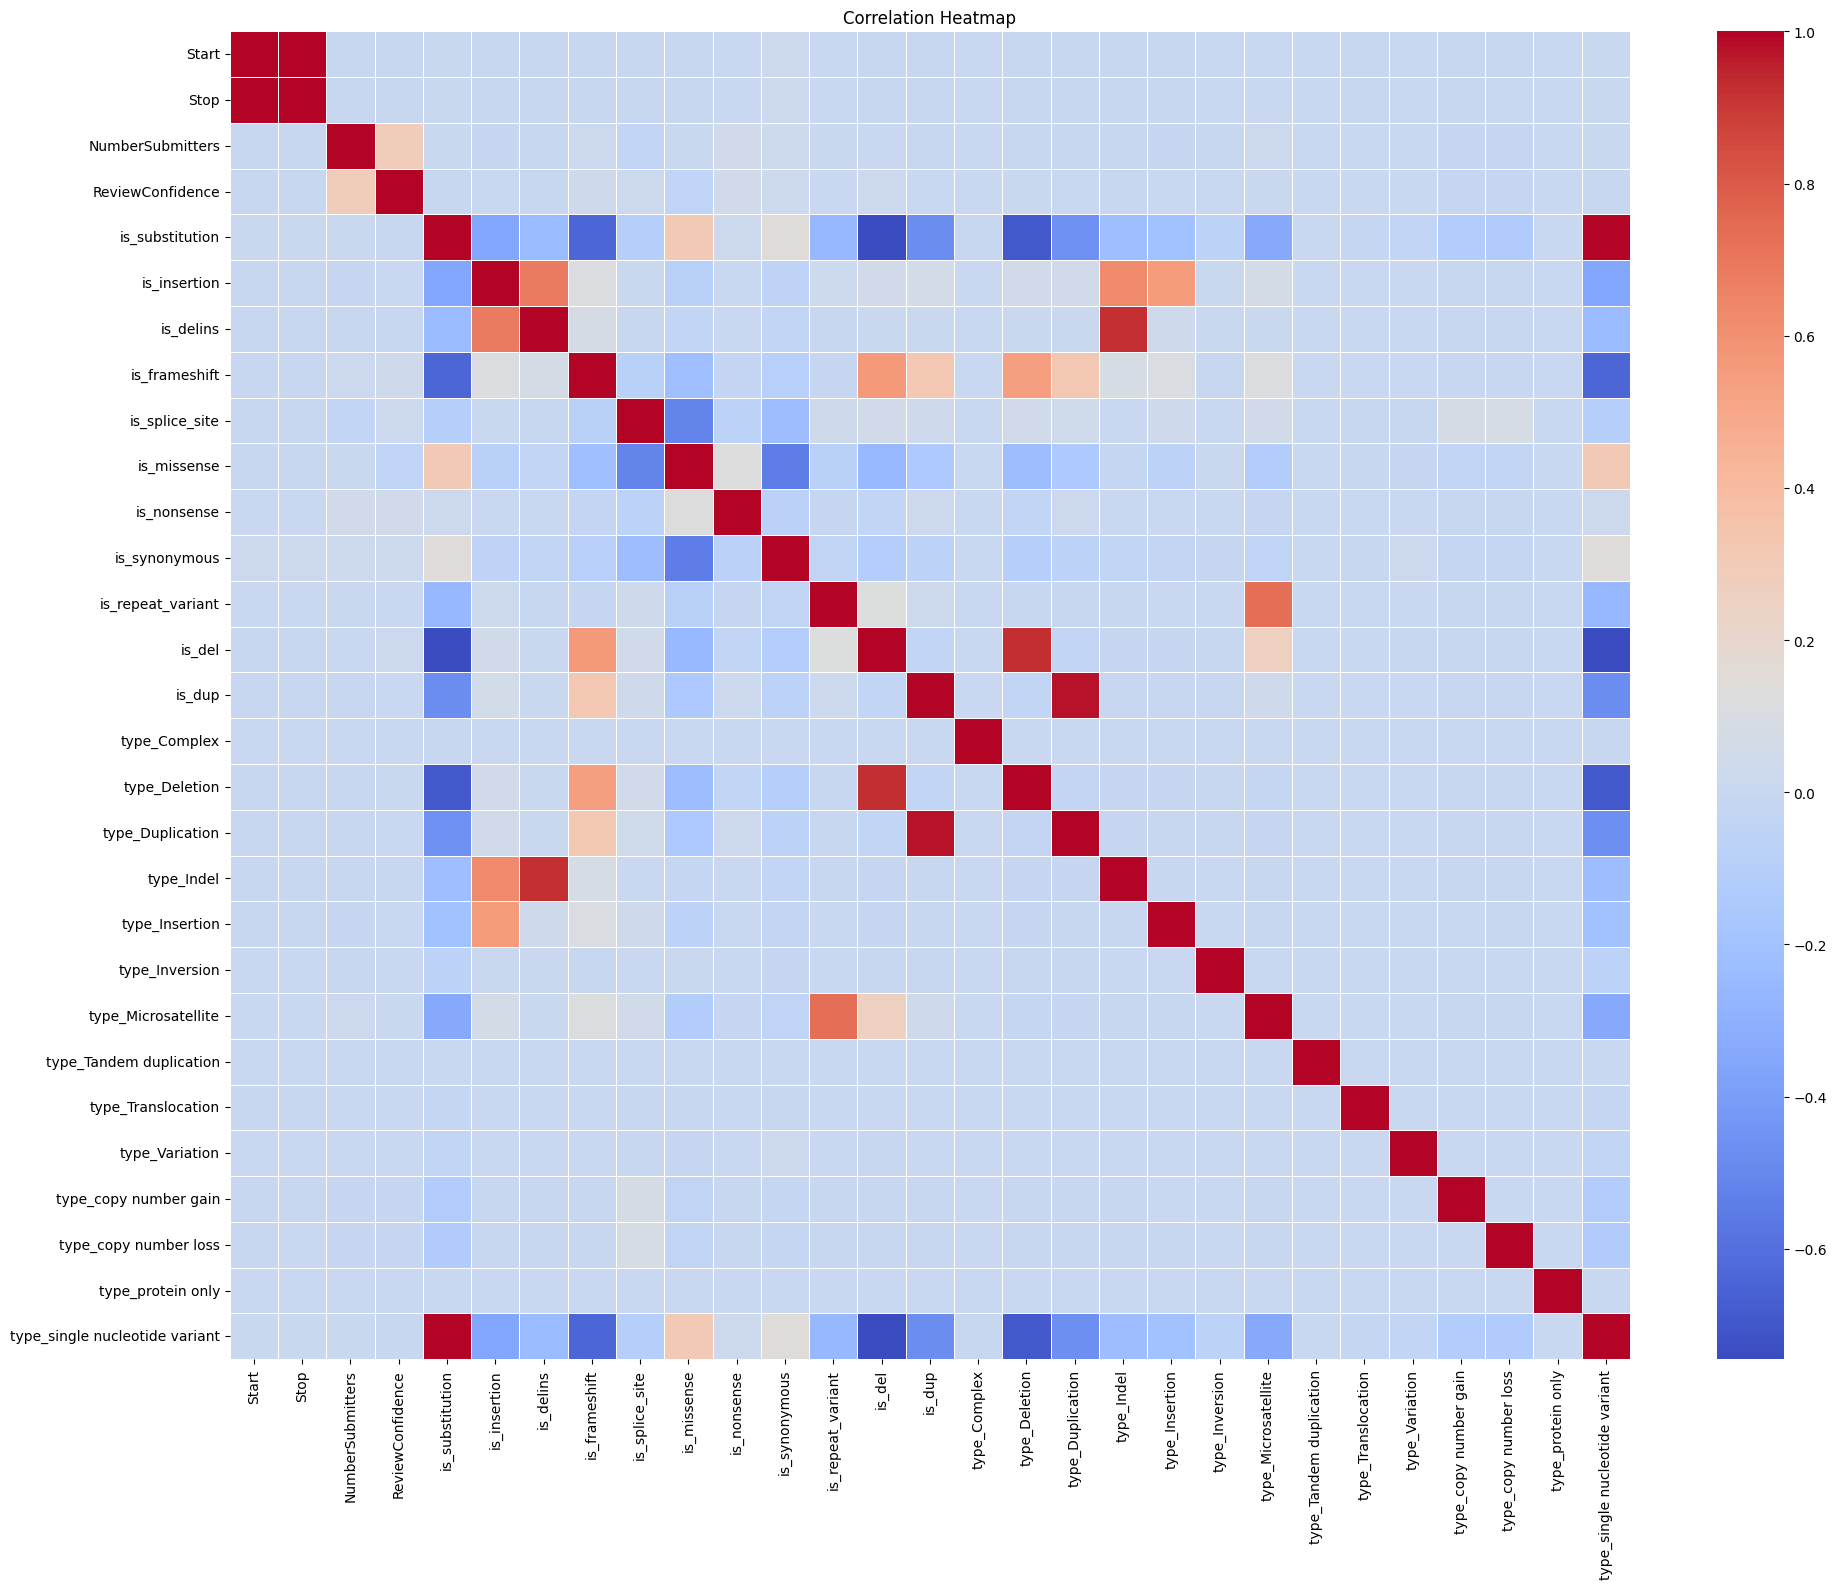

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Draw the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# Correlation between the columns
correlation = final_df[['is_dup','type_Duplication']].corr()
print(correlation)


                    is_dup  type_Duplication
is_dup            1.000000          0.978133
type_Duplication  0.978133          1.000000


In [ ]:
# Correlation between the columns
correlation = final_df[['is_substitution','type_single nucleotide variant']].corr()
print(correlation)


                                is_substitution  \
is_substitution                        1.000000   
type_single nucleotide variant         0.998836   

                                type_single nucleotide variant  
is_substitution                                       0.998836  
type_single nucleotide variant                        1.000000  


In [ ]:
# Correlation between the columns
correlation = final_df[['is_delins','type_Indel']].corr()
print(correlation)


            is_delins  type_Indel
is_delins    1.000000    0.920594
type_Indel   0.920594    1.000000


In [ ]:
# Correlation between the columns
correlation = final_df[['is_del','type_Deletion']].corr()
print(correlation)


                 is_del  type_Deletion
is_del         1.000000       0.928606
type_Deletion  0.928606       1.000000


In [ ]:
# Dropping the redundant columns including 'stop'
final_df = final_df.drop(columns=['is_dup', 'is_substitution', 'is_delins', 'is_del', 'Stop'])

# Checking the first few rows after dropping the columns
print(final_df.head())


                        Type  \
0                      Indel   
1                      Indel   
2  single nucleotide variant   
3  single nucleotide variant   
4  single nucleotide variant   

                                                Name GeneSymbol  \
0  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
1  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
2        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
3        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
4       NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser)    FOXRED1   

             Origin Chromosome      Start  \
0  germline;unknown          7    4820844   
1  germline;unknown          7    4781213   
2          germline         11  126145284   
3          germline         11  126275389   
4          germline         11  126147412   

                                        ReviewStatus  NumberSubmitters  \
0  criteria provided, multiple submitters, no con...       

In [ ]:
# Compute correlation matrix
correlation_matrix = final_df.corr(numeric_only=True)

# Display the correlation matrix
print(correlation_matrix)


                                   Start  NumberSubmitters  ReviewConfidence  \
Start                           1.000000         -0.006070         -0.008733   
NumberSubmitters               -0.006070          1.000000          0.279563   
ReviewConfidence               -0.008733          0.279563          1.000000   
is_insertion                   -0.004357         -0.010801         -0.000582   
is_frameshift                  -0.005766          0.014935          0.036679   
is_splice_site                 -0.002899         -0.032947          0.014900   
is_missense                    -0.003831          0.005171         -0.049215   
is_nonsense                     0.003833          0.046380          0.049328   
is_synonymous                   0.011807          0.027361          0.028602   
is_repeat_variant               0.000349          0.009297         -0.001989   
type_Complex                   -0.000615         -0.000466         -0.000459   
type_Deletion                  -0.005074

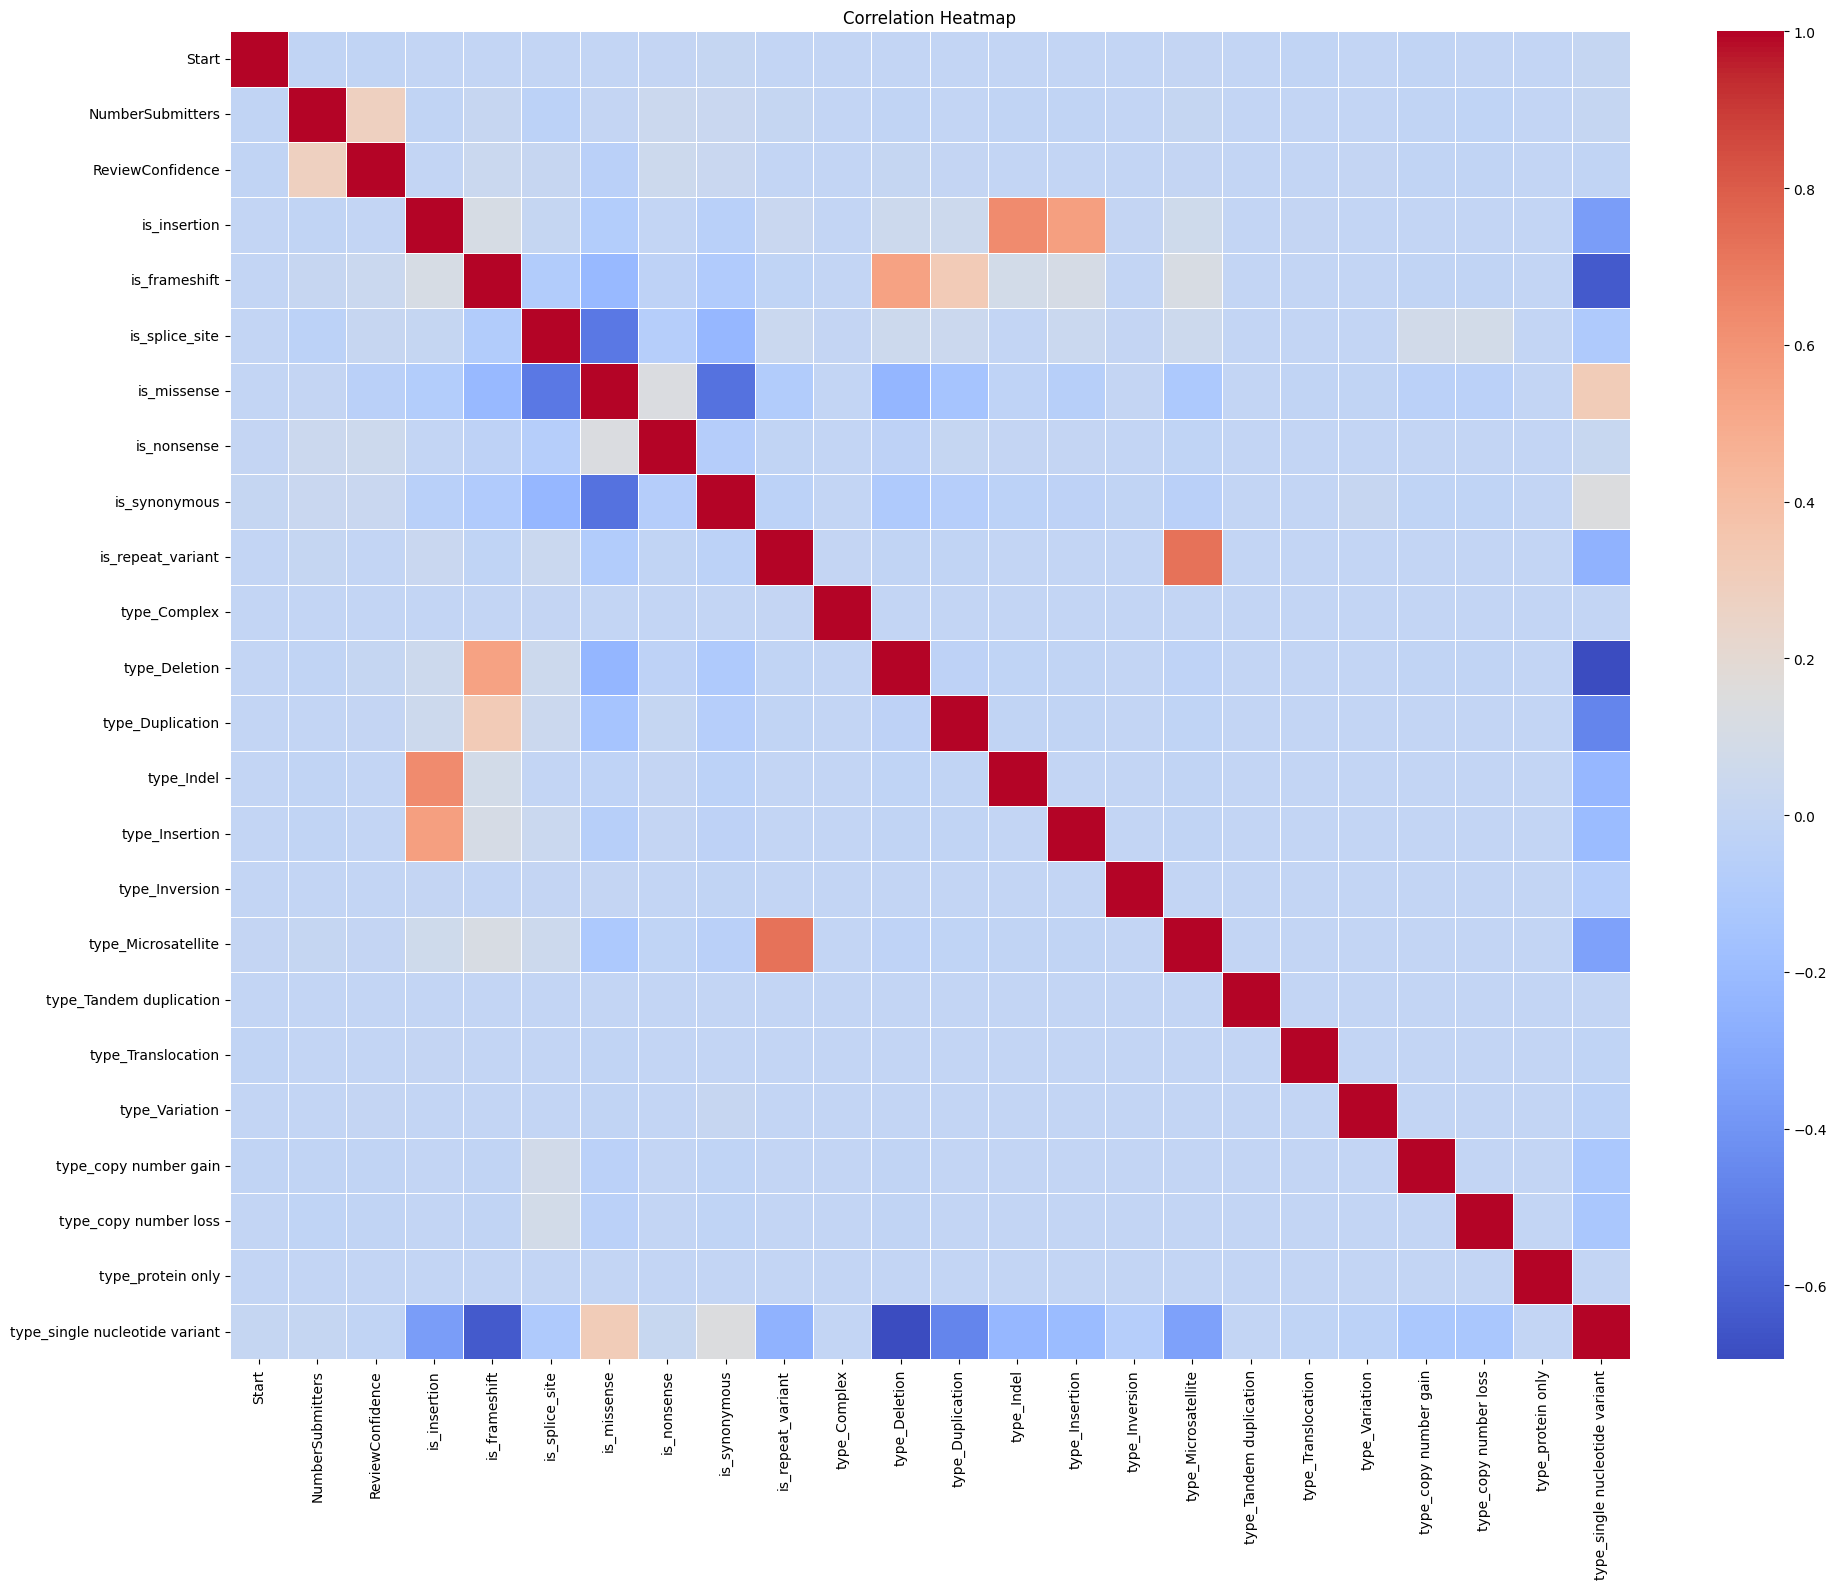

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Draw the heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [ ]:
# Dropping the redundant columns including 'stop'
final_df = final_df.drop(columns=['is_insertion'])

# Checking the first few rows after dropping the columns
print(final_df.head())


                        Type  \
0                      Indel   
1                      Indel   
2  single nucleotide variant   
3  single nucleotide variant   
4  single nucleotide variant   

                                                Name GeneSymbol  \
0  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
1  NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...      AP5Z1   
2        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
3        NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter)    FOXRED1   
4       NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser)    FOXRED1   

             Origin Chromosome      Start  \
0  germline;unknown          7    4820844   
1  germline;unknown          7    4781213   
2          germline         11  126145284   
3          germline         11  126275389   
4          germline         11  126147412   

                                        ReviewStatus  NumberSubmitters  \
0  criteria provided, multiple submitters, no con...       

In [ ]:
final_df.columns

Index(['Type', 'Name', 'GeneSymbol', 'Origin', 'Chromosome', 'Start',
       'ReviewStatus', 'NumberSubmitters', 'Grouped_ClinicalSignificance',
       'ReviewConfidence', 'transcript', 'is_frameshift', 'is_splice_site',
       'is_missense', 'is_nonsense', 'is_synonymous', 'is_repeat_variant',
       'type_Complex', 'type_Deletion', 'type_Duplication', 'type_Indel',
       'type_Insertion', 'type_Inversion', 'type_Microsatellite',
       'type_Tandem duplication', 'type_Translocation', 'type_Variation',
       'type_copy number gain', 'type_copy number loss', 'type_protein only',
       'type_single nucleotide variant'],
      dtype='object')

In [ ]:
# Drop the 'transcript' column from your dataset
final_df = final_df.drop(columns=['transcript'])


In [ ]:
final_df.to_csv('cleaned_variant_data_final.csv', index=False)


In [ ]:
final_df.to_csv('/content/drive/MyDrive/cleaned_variant_data_final.csv', index=False)